
### Amazon fine food review - Apply Naive Bayes
 - Objective: For a given review determine wheather it is positive or negative using Naive bias.


In [6]:
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split


In [7]:
# using the SQLite Table to read data.
con = sqlite3.connect("../dataset/database.sqlite") 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Exploratory Data Analysis

In [8]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

### Data Cleaning - Deduplication
- It is necessary to remove duplicates data which have same UserId,Time,Text in order to prevent bais analysis of data.

In [10]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

### Observation - The data that remains after de-duplication is equal to 364173 with 10 features.

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

### Observation- About 69% of data is remaining after deduplication.

- Getting the Reviews where Helpfulness Numerator is greater than Helpfulness Denominator.

In [12]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


- Observation-  For these two data we see that helpfulness numerator is greater than helpfulness denominator which is not practically possible.

In [13]:
## Discarding the data where numerator is greater than denominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


Score
1    307061
0     57110
Name: count, dtype: int64

#### Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

- Begin by removing the html tags
- Remove any punctuations or limited set of special characters like , or . or # etc.
- Check if the word is made up of english letters and is not alpha-numeric
- Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
- Convert the word to lowercase
- Remove Stopwords
- Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
- After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


- Observation - These are all the reviews which have HTML tags.

In [16]:
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'their', 'will', 'against', 'shouldn', 'are', 'y', 'be', 'when', 'your', "shouldn't", "weren't", 'shan', 'only', 'haven', 'myself', 'as', 'once', 'isn', 'further', 'any', 'we', "don't", 'no', 'each', 'and', 'before', 'where', "hadn't", 'off', 'very', 'needn', 'do', 'didn', 'can', 'o', 'few', "aren't", 'this', 'them', "you're", 'then', 'during', "shan't", 'to', 'd', 'while', 're', "hasn't", 'don', 'is', 'our', 'or', 'through', 'it', 'under', 'at', 'mustn', 'won', 'there', 'just', 'him', "you'd", 'down', 'not', 'm', "isn't", 'ourselves', 'between', 'other', "couldn't", 'been', "wasn't", 'her', 'herself', 'had', "mightn't", 'an', 'for', "needn't", "it's", 'being', 've', 'that', 'below', 'over', 'whom', 'ain', "you've", 'now', 's', "haven't", 'on', 'until', 'some', 'up', 'such', 'own', 'he', 'aren', 'have', "she's", 'were', 'has', 'about', "won't", 'she', 'more', 'yourselves', 'so', 'wasn', 'wouldn', 'nor', 'the', 'who', 'did', "you'll", 'hadn', 'theirs', 'why', 'what', 't', 'with', 'hasn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- ##### Observation- These are all the stopwords which have to be removed, and also the stemming of word 'tasty' give result as 'tasti' .

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 


In [19]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('../dataset/final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

364171

In [20]:
con = sqlite3.connect("../dataset/final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [21]:
cleaned_data.shape

(364171, 12)

In [22]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [23]:
cleaned_data["Score"].value_counts()

Score
1    307061
0     57110
Name: count, dtype: int64

#### Randomly sample 100k data points.

In [24]:
# To randomly sample 100k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

In [25]:
# create design matrix X and target vector y
X = np.array(random_sample_data.iloc[:,:]) # end index is exclusive
y = np.array(random_sample_data['Score']) # showing you two ways of indexing a pandas df

#### Splitting the data 

In [26]:
# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)

### Bag of Words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train[:,9]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train[:,9])
X_cv_bow = vectorizer.transform(X_cv[:,9])
X_test_bow = vectorizer.transform(X_test[:,9])
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

After vectorizations
(49000, 43971) (49000,)
(21000, 43971) (21000,)
(30000, 43971) (30000,)
(49000,)
(21000,)
(30000,)


### Multinomial Naive Bayes on BOW

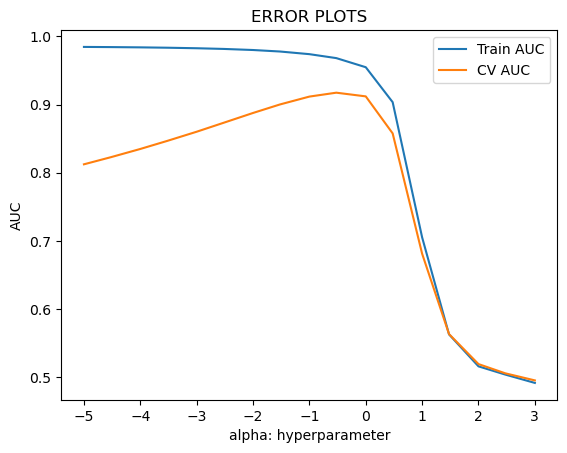

In [28]:
# Function to compute alpha value
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []

alpha_values = np.array([0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,30,100,300,1000])
for alpha in alpha_values:
    mnb=MultinomialNB(alpha=alpha,class_prior=[0.5,0.5])
    mnb.fit(X_train_bow, y_train)
    y_train_pred =  mnb.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  mnb.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

#### Observation - From the above plot we can say say optimal value of alpha is equal to 1.

In [29]:
optimal_alpha = 1

### Plotting ROC_AUC Curve

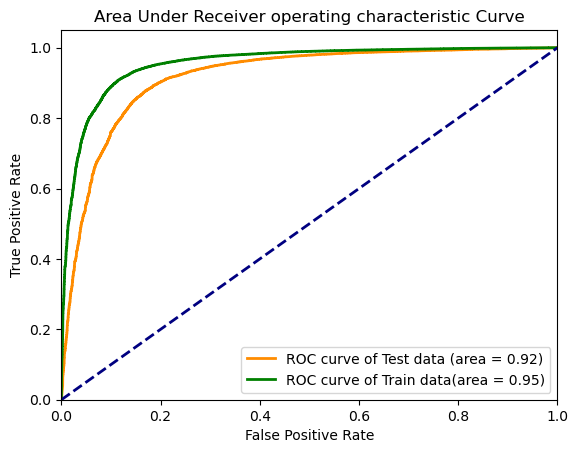

In [30]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


mnb = MultinomialNB(alpha=optimal_alpha,class_prior=[0.5,0.5])
mnb.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, mnb.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, mnb.predict_proba(X_test_bow)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")
    

##### Observation
- AUC Train = 0.95
- AUC Test = 0.91

### Confusion Matrix


Text(50.722222222222214, 0.5, 'True Label')

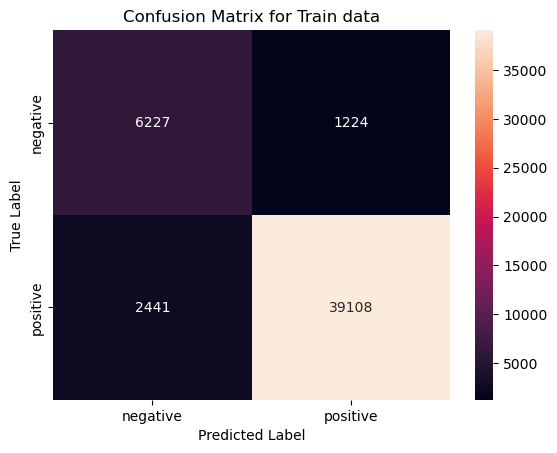

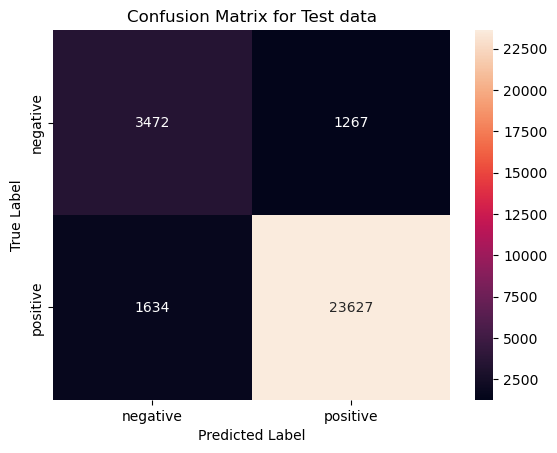

In [31]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, mnb.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, mnb.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
    

#### Observation -

- From the Confusion Matrix of train data 6416 points are correctly classified as negative points and 38794  points are correctly classified as positive points.

-  From the Confusion Matrix of test data 3438 points are correctly classified as negative points and 23573  points are correctly classified as positive points.


### Tf-idf

In [39]:
#tf-idf on train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) #considering only uni-gram as I was getting memory error
train_tfidf = tf_idf_vect.fit_transform(X_train[:,9]) #sparse matrix
cv_tfidf= tf_idf_vect.transform(X_cv[:,9])
test_tfidf = tf_idf_vect.transform(X_test[:,9])
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(49000, 43971)
(21000, 43971)
(30000, 43971)


### Multinomial Naive Bayes on TFIDF

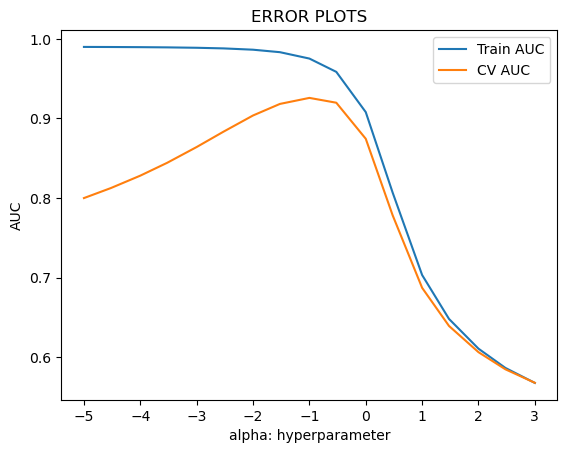

In [40]:
# Function to compute alpha value
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_auc = []
cv_auc = []

alpha_values = np.array([0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,30,100,300,1000])
for alpha in alpha_values:
    mnb=MultinomialNB(alpha=alpha,class_prior=[0.5,0.5])
    mnb.fit(train_tfidf, y_train)
    y_train_pred =  mnb.predict_proba(train_tfidf)[:,1]
    y_cv_pred =  mnb.predict_proba(cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Observation -
#### From above plot we can see that optimal value of alpha is equal to 0.1 .

In [41]:
# By looking at the validation and traing curve we can say that
tfidf_optimal_alpha = 0.1

### Plotting ROC_AUC curve 

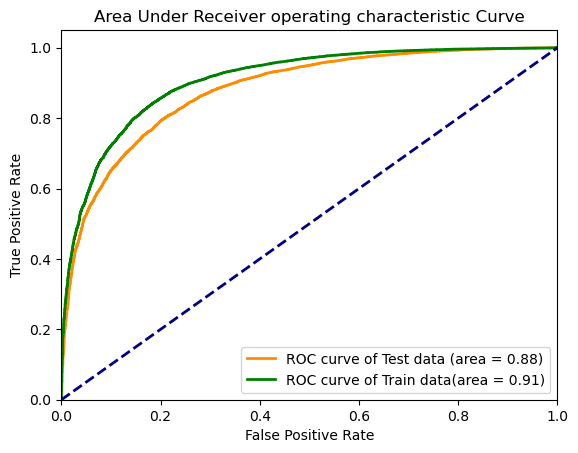

In [42]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


mnb = MultinomialNB(alpha=optimal_alpha,class_prior=[0.5,0.5])
mnb.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, mnb.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, mnb.predict_proba(test_tfidf)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")
    

### Observation
- AUC Train = 0.91
- AUC Test = 0.88

### Confusion Matrix

Text(50.722222222222214, 0.5, 'True Label')

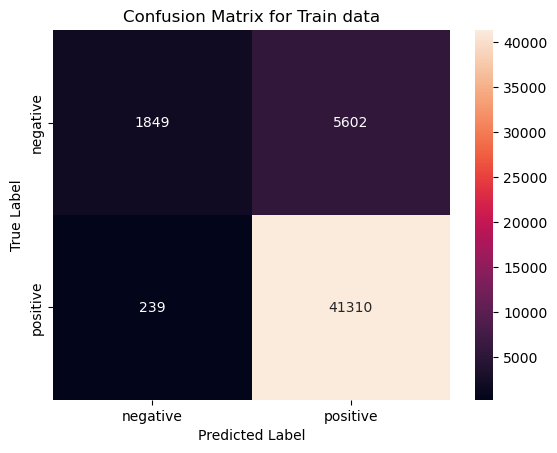

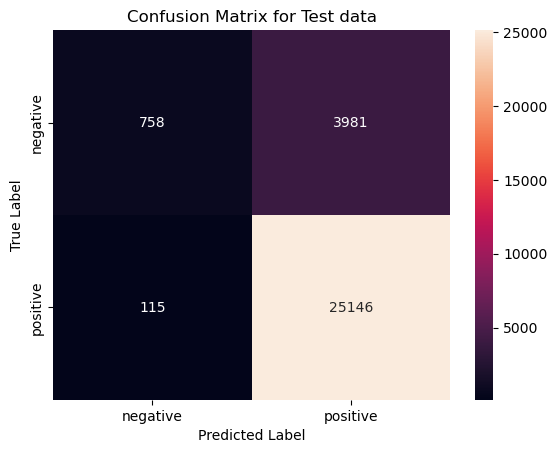

In [43]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, mnb.predict(train_tfidf))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, mnb.predict(test_tfidf))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
    


### Observation
-  From the Confusion Matrix of train data 2028 points are correctly classified as negative points and 41045 points are correctly classified as positive points.
-  From the Confusion Matrix of tests data 805 points are correctly classified as negative points and 25147  points are correctly classified as positive points.



### Conclusion

In [45]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Algorithm(Multinomial Naive Bayes)", "Optimal value of alpha" , "Train_data_AUC", "Test_data_AUC"]
x.add_row(["Naive Bayes with BOW  " , 1.0 , 0.95 , 0.91  ])
x.add_row(["Naive Bayes with TfIdf" , 0.1 , 0.91 , 0.88  ])

print(x)


+------------------------------------+------------------------+----------------+---------------+
| Algorithm(Multinomial Naive Bayes) | Optimal value of alpha | Train_data_AUC | Test_data_AUC |
+------------------------------------+------------------------+----------------+---------------+
|       Naive Bayes with BOW         |          1.0           |      0.95      |      0.91     |
|       Naive Bayes with TfIdf       |          0.1           |      0.91      |      0.88     |
+------------------------------------+------------------------+----------------+---------------+


#### From above table we can say Multinomial Naive Bayes works better with BOW vectorizer.